## Loading Data

In [1]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import re
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

In [2]:
dim = 256 
seq_len =  100
batch_size = 64

In [3]:
#cpu_df = pd.read_csv('machine_317477951_1sec.csv', delimiter=',' ,skiprows=1, header=None,names = ['Start time','End time','JobID','Task Index','MachineID', 'Mean CPU usage rate', 'Canonical Memory','Assigned Memory','Unmapped page cache memory', 'Total page cache memory', 'max mem usage', 'mean disk io time','mean local disk space used', 'max cpu usage', 'max disk IO time', 'CPI','MAI','sample portion','aggregation type','sampled cpu usage'])
cpu_df = pd.read_csv('Data/Book1.csv')
cpu_df.head()

,CPU load,CPU_load_normalized
0,49.98,0.4998
1,51.06,0.5106
2,56.01,0.5601
3,80.25,0.8025
4,75.81,0.7581


In [4]:
cpu_df.shape

(990, 2)

In [5]:
# Changing start time from micro seconds to date
# cpu_df['Start time'] =  pd.to_datetime(cpu_df['Start time'])
# cpu_df['Start time'] = cpu_df['Start time'].apply(lambda x: re.findall(r'\d{4}-\d{2}-\d{2}\s\d{2}', str(x))[0])
# cpu_df.sort_values('Start time', inplace=True)

In [6]:
# thinking to be not needed jobid, task id , machine id, mean disk IO time, max disk IO time, sample portion

In [7]:
cpu_df.describe()

,CPU load,CPU_load_normalized
count,990.000000,990.000000
mean,79.725899,0.797259
std,12.028060,0.120281
min,49.670000,0.496700
25%,72.055000,0.720550
50%,81.325000,0.813250
75%,89.447500,0.894475
max,99.950000,0.999500


In [8]:
cpu_df.isna().sum()

CPU load               0
CPU_load_normalized    0
dtype: int64

In [9]:
# thinking to be not needed jobid, task id , machine id, mean disk IO time, max disk IO time, sample portion

In [10]:
cpu_df.columns

Index(['CPU load', 'CPU_load_normalized'], dtype='object')

In [11]:
cpu_df = cpu_df.drop(['CPU load'], axis = 1)

In [12]:
# cpu_df['CPI'].fillna(inplace=True, method='ffill') 
# cpu_df['MAI'].fillna(inplace=True, method='ffill')

In [13]:
cpu_df.isna().sum()

CPU_load_normalized    0
dtype: int64

## EDA

In [14]:
# removing aggregation type, MAI, CPI, mean local disk space
cpu_df1 = cpu_df.copy()

In [15]:
# cpu_df1 = cpu_df1.drop(['MAI','CPI','mean local disk space used','aggregation type'], axis = 1)

In [16]:
cpu_df1.head()

,CPU_load_normalized
0,0.4998
1,0.5106
2,0.5601
3,0.8025
4,0.7581


In [17]:
cpu_df = cpu_df1.copy()

## Plotting

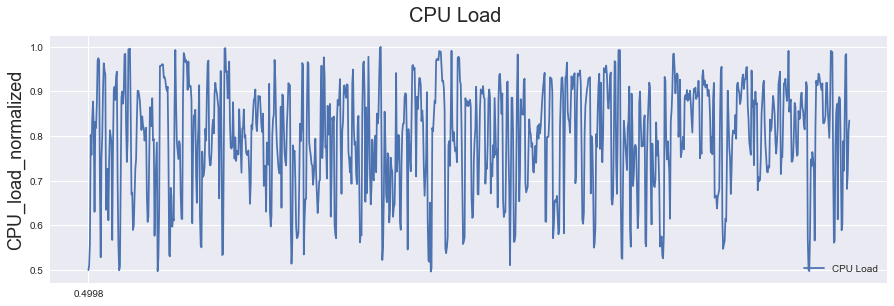

In [18]:
fig = plt.figure(figsize=(15,10))
title = fig.suptitle("CPU Load", fontsize=20)
title.set_y(0.92)

axis1 = fig.add_subplot(211)
axis1.plot(cpu_df['CPU_load_normalized'], label='CPU Load')
axis1.set_xticks(range(0, cpu_df.shape[0], 1464))
axis1.set_xticklabels(cpu_df['CPU_load_normalized'].loc[::1464])
axis1.set_ylabel('CPU_load_normalized', fontsize=18)
axis1.legend()

# axis2 = fig.add_subplot(212)
# axis2.plot(cpu_df['Assigned Memory'], label='Assigned Memory')
# axis2.set_xticks(range(0, cpu_df.shape[0], 1464))
# axis2.set_xticklabels(cpu_df['Start time'].loc[::1464])
# axis2.set_ylabel('Assigned Memory', fontsize=18)
# axis2.legend()

## Making data statonary

In [19]:
cpu_df.shape

(990, 1)

In [20]:
# # Method 1: Differencing and seasonal differencing(seasonal diff = shift(7))
# cpu_df['mcur'] = cpu_df['CPU_load_normalized'] - cpu_df['CPU_load_normalized'].shift(1)

In [21]:
# # Method 2: Transformation + differencing
# cpu_df['mcur1'] = np.log(cpu_df['Mean CPU usage rate'])
# # cpu_df['mcur1'] = np.sqrt(cpu_df['Mean CPU usage rate'])
# # cpu_df['mcur1'] = np.cbrt(cpu_df['Mean CPU usage rate'])

# cpu_df['mcur1'] = cpu_df['mcur1'] - cpu_df['mcur1'].shift(1)

In [22]:
# Method 3: Rolling Statistics
cpu_df['mcur2'] = cpu_df['CPU_load_normalized'].rolling(window = 7).mean()

In [23]:
cpu_df.shape

(990, 2)

In [24]:
cpu_df.head(10)

,CPU_load_normalized,mcur2
0,0.4998,NaN
1,0.5106,NaN
2,0.5601,NaN
3,0.8025,NaN
4,0.7581,NaN
5,0.8385,NaN
6,0.8771,0.692386
7,0.8190,0.737986
8,0.6305,0.755114
9,0.8319,0.793943


In [25]:
cpu_df = cpu_df.iloc[6: , :]

In [26]:
cpu_df.head()

,CPU_load_normalized,mcur2
6,0.8771,0.692386
7,0.8190,0.737986
8,0.6305,0.755114
9,0.8319,0.793943
10,0.8180,0.796157


## Train test split

In [27]:
# Train-Test split
no_rows = sorted(cpu_df.index.values)
last_10p = sorted(cpu_df.index.values)[-int(0.1*len(no_rows))]
last_20p = sorted(cpu_df.index.values)[-int(0.2*len(no_rows))]

df_train = cpu_df[(cpu_df.index < last_20p)]  # Training data are 80% of total data
df_val = cpu_df[(cpu_df.index >= last_20p) & (cpu_df.index < last_10p)] # Validation and test data 10% each
df_test = cpu_df[(cpu_df.index >= last_10p)]

In [28]:
# Remove date column
# df_train.drop(columns=['Start time'], inplace=True)
# df_val.drop(columns=['Start time'], inplace=True)
# df_test.drop(columns=['Start time'], inplace=True)

In [29]:
df_train.shape

(788, 2)

In [30]:
# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data: {0}'.format(train_data.shape))
print('Validation data: {0}'.format(val_data.shape))
print('Test data: {0}'.format(test_data.shape))

df_train.head(40)

Training data: (788, 2)
Validation data: (98, 2)
Test data: (98, 2)


,CPU_load_normalized,mcur2
6,0.8771,0.692386
7,0.8190,0.737986
8,0.6305,0.755114
9,0.8319,0.793943
10,0.8180,0.796157
11,0.8738,0.812686
12,0.9687,0.831286
13,0.9743,0.845171
14,0.9687,0.866557
15,0.6866,0.874571


## Plot daily changes of close prices and volume

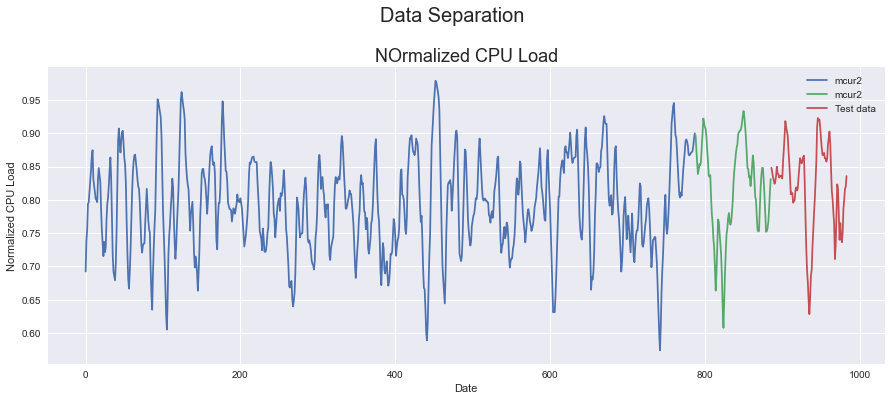

In [31]:
fig = plt.figure(figsize=(15,12))
title = fig.suptitle("Data Separation", fontsize=20)
title.set_y(0.95)

# Plotting normalized Close prices
axis1 = fig.add_subplot(211)
axis1.plot(np.arange(train_data.shape[0]), df_train['mcur2'], label='mcur2')
axis1.plot(np.arange(train_data.shape[0], train_data.shape[0]+val_data.shape[0]), df_val['mcur2'], label='mcur2')
axis1.plot(np.arange(train_data.shape[0]+val_data.shape[0],  train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['mcur2'], label='Test data')
axis1.set_xlabel('Date')
axis1.set_ylabel('Normalized CPU Load')
axis1.set_title("NOrmalized CPU Load", fontsize=18)
axis1.legend()

# # Plotting normalized volume changes
# axis2 = fig.add_subplot(212)
# axis2.plot(np.arange(train_data.shape[0]), df_train['Assigned Memory'], label='Training data')
# axis2.plot(np.arange(train_data.shape[0], train_data.shape[0]+val_data.shape[0]), df_val['Assigned Memory'], label='Validation data')
# axis2.plot(np.arange(train_data.shape[0]+val_data.shape[0], train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Assigned Memory'], label='Test data')
# axis2.set_xlabel('Date')
# axis2.set_ylabel('Normalized Assigned Memory')
# axis2.set_title("Assigned Memory", fontsize=18)
# axis2.legend()

## Generating training, validation and test data seqences

In [32]:
seq_len =60
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
    X_train.append(train_data[i - seq_len:i,1])
    y_train.append(train_data[:, 1][i]) 
X_train, y_train = np.array(X_train), np.array(y_train)


# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i,1])
    y_val.append(val_data[:, 1][i])
X_val, y_val = np.array(X_val), np.array(y_val)


# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i,1])
    y_test.append(test_data[:, 1][i])
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training seq shape:', X_train.shape, y_train.shape)
print('Validation seq shape:', X_val.shape, y_val.shape)
print('Testing seq shape:' ,X_test.shape, y_test.shape)

Training seq shape: (728, 60) (728,)
Validation seq shape: (38, 60) (38,)
Testing seq shape: (38, 60) (38,)


## Layers

In [33]:
# Time2Vector Layer

class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        self.weights_linear = self.add_weight(name='weight_linear', shape=(int(self.seq_len),), initializer='uniform', 
                                              trainable=True)
        self.bias_linear = self.add_weight(name='bias_linear', shape=(int(self.seq_len),), initializer='uniform', 
                                           trainable=True)
        self.weights_periodic = self.add_weight(name='weight_periodic', shape=(int(self.seq_len),), initializer='uniform', 
                                                trainable=True)
        self.bias_periodic = self.add_weight(name='bias_periodic', shape=(int(self.seq_len),), initializer='uniform', 
                                             trainable=True)

    def call(self, x):
        x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear 
        time_linear = tf.expand_dims(time_linear, axis=-1)
    
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1)
        
        return tf.concat([time_linear, time_periodic], axis=-1)
   
    def get_config(self): 
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config

## Model

In [34]:
# Dropout.
# Layers.
# Regularization.
# Optimization Algorithm.
# Loss Function. 
# Features and Timesteps. 
# Larger Batch Size.

In [35]:
# 1. You can difference your series
# 2. You can denoise.
# 3. You can remove seasonality.

In [88]:
def build_model():
    time = Time2Vector(seq_len)
    lstm1 = LSTM(64,return_sequences=True, activation='relu')
    lstm2=  LSTM(32, activation='relu')
#     lstm3=  LSTM(16,return_sequences=True, activation='relu')
#     lstm4=  LSTM(12, activation='relu')
    
    inp = Input(shape=(seq_len, 1))
    x = time(inp)
    x= Concatenate(axis=-1)([inp, x])
    x = lstm1((x))
    x = Dropout(0.2)(x)
    x = lstm2((x))
#     x = lstm3((x))
#     x = lstm4((x))
    x = Dense(10, activation='relu')(x)
    #x = Dropout(0.2)(x)
    out = Dense(1)(x)
    
    m = Model(inp, out)
    m.compile(loss='mse', optimizer='adam', metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
    
    return m

In [89]:
X_train.shape

(728, 60)

In [90]:
model = build_model()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
time2_vector_14 (Time2Vector)   (None, 60, 2)        240         input_9[0][0]                    
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 60, 3)        0           input_9[0][0]                    
                                                                 time2_vector_14[0][0]            
__________________________________________________________________________________________________
lstm_25 (LSTM)                  (None, 60, 64)       17408       concatenate_8[0][0]        

In [91]:
callback = tf.keras.callbacks.ModelCheckpoint('Models/LSTM_S.hdf5', monitor='val_loss', save_best_only=True, verbose=1)
history = model.fit(X_train, y_train, batch_size=32, epochs=40, callbacks=[callback],  validation_data=(X_val, y_val))  

Epoch 1/40
23/23 [==============================] - 3s 39ms/step - loss: 0.2077 - mae: 0.3706 - root_mean_squared_error: 0.4558 - val_loss: 0.0117 - val_mae: 0.0956 - val_root_mean_squared_error: 0.1082

Epoch 00001: val_loss improved from inf to 0.01172, saving model to Models\LSTM_S.hdf5
Epoch 2/40
23/23 [==============================] - 1s 29ms/step - loss: 0.0121 - mae: 0.0900 - root_mean_squared_error: 0.1098 - val_loss: 0.0031 - val_mae: 0.0422 - val_root_mean_squared_error: 0.0561

Epoch 00002: val_loss improved from 0.01172 to 0.00315, saving model to Models\LSTM_S.hdf5
Epoch 3/40
23/23 [==============================] - 1s 29ms/step - loss: 0.0068 - mae: 0.0652 - root_mean_squared_error: 0.0823 - val_loss: 0.0025 - val_mae: 0.0397 - val_root_mean_squared_error: 0.0503

Epoch 00003: val_loss improved from 0.00315 to 0.00253, saving model to Models\LSTM_S.hdf5
Epoch 4/40
23/23 [==============================] - 1s 31ms/step - loss: 0.0060 - mae: 0.0616 - root_mean_squared_error

23/23 [==============================] - 1s 46ms/step - loss: 0.0044 - mae: 0.0530 - root_mean_squared_error: 0.0663 - val_loss: 0.0032 - val_mae: 0.0466 - val_root_mean_squared_error: 0.0565

Epoch 00031: val_loss did not improve from 0.00175
Epoch 32/40
23/23 [==============================] - 1s 44ms/step - loss: 0.0039 - mae: 0.0501 - root_mean_squared_error: 0.0623 - val_loss: 0.0018 - val_mae: 0.0352 - val_root_mean_squared_error: 0.0428

Epoch 00032: val_loss did not improve from 0.00175
Epoch 33/40
23/23 [==============================] - 1s 45ms/step - loss: 0.0040 - mae: 0.0506 - root_mean_squared_error: 0.0630 - val_loss: 0.0025 - val_mae: 0.0415 - val_root_mean_squared_error: 0.0499

Epoch 00033: val_loss did not improve from 0.00175
Epoch 34/40
23/23 [==============================] - 1s 51ms/step - loss: 0.0038 - mae: 0.0487 - root_mean_squared_error: 0.0613 - val_loss: 0.0021 - val_mae: 0.0384 - val_root_mean_squared_error: 0.0458

Epoch 00034: val_loss did not improve f

In [92]:
model = tf.keras.models.load_model('Models/LSTM_S.hdf5', custom_objects={'Time2Vector': Time2Vector})

## Evaluation

In [93]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)


# Evaluation for train, val and test data
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print('Evaluation metrics')
print('Train Data - Loss: {:.5f}, MAE: {:.5f}, RMSE: {:.5f}'.format(train_eval[0], train_eval[1],  train_eval[2]))
print('Validation Data - Loss: {:.5f}, MAE: {:.5f}, RMSE: {:.5f}'.format(val_eval[0], val_eval[1],  val_eval[2]))
print('Test Data - Loss: {:.5f}, MAE: {:.5f}, RMSE: {:.5f}'.format(test_eval[0], test_eval[1],  test_eval[2]))

Evaluation metrics
Train Data - Loss: 0.00233, MAE: 0.03882, RMSE: 0.04827
Validation Data - Loss: 0.00173, MAE: 0.03627, RMSE: 0.04162
Test Data - Loss: 0.00192, MAE: 0.03813, RMSE: 0.04379


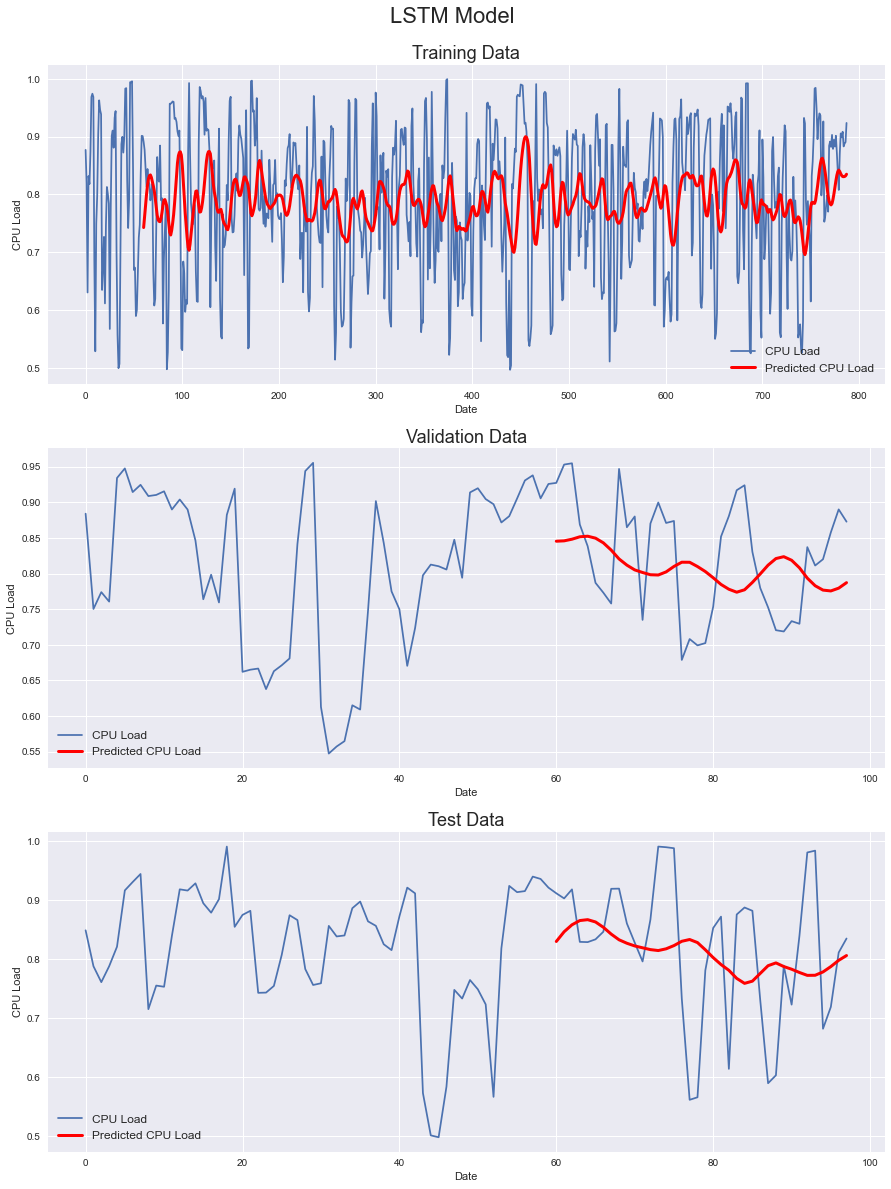

In [94]:
fig = plt.figure(figsize=(15,20))
title = fig.suptitle("LSTM Model", fontsize=22)
title.set_y(0.92)

#Plot training data results
axis1 = fig.add_subplot(311)
axis1.plot(train_data[:, 0], label='CPU Load')
axis1.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred,color = 'r', linewidth=3, label='Predicted CPU Load')
axis1.set_title("Training Data", fontsize=18)
axis1.set_xlabel('Date')
axis1.set_ylabel('CPU Load')
axis1.legend(loc="best", fontsize=12)

#Plot validation data results
axis2 = fig.add_subplot(312)
axis2.plot(val_data[:, 0], label='CPU Load')
axis2.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, color = 'r',linewidth=3, label='Predicted CPU Load')
axis2.set_title("Validation Data", fontsize=18)
axis2.set_xlabel('Date')
axis2.set_ylabel('CPU Load')
axis2.legend(loc="best", fontsize=12)

#Plot test data results
axis3 = fig.add_subplot(313)
axis3.plot(test_data[:, 0], label='CPU Load')
axis3.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, color = 'r',linewidth=3, label='Predicted CPU Load')
axis3.set_title("Test Data", fontsize=18)
axis3.set_xlabel('Date')
axis3.set_ylabel('CPU Load')
axis3.legend(loc="best", fontsize=12)

## Model metrics

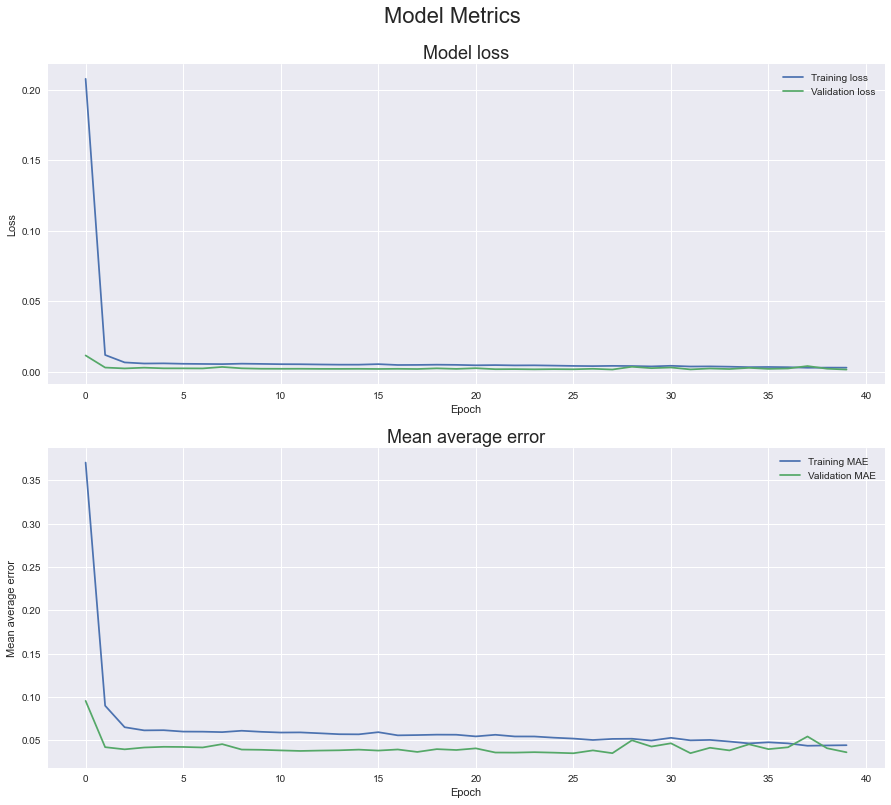

In [95]:
# Plot Model Metrics
fig = plt.figure(figsize=(15,20))
title = fig.suptitle("Model Metrics", fontsize=22)
title.set_y(0.92)

#Plot model loss
axis1 = fig.add_subplot(311)
axis1.plot(history.history['loss'], label='Training loss')
axis1.plot(history.history['val_loss'], label='Validation loss')
axis1.set_title("Model loss", fontsize=18)
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss')
axis1.legend()

#Plot MAE
axis2 = fig.add_subplot(312)
axis2.plot(history.history['mae'], label='Training MAE')
axis2.plot(history.history['val_mae'], label='Validation MAE')
axis2.set_title("Mean average error", fontsize=18)
axis2.set_xlabel('Epoch')
axis2.set_ylabel('Mean average error')
axis2.legend()

In [64]:
# tf.keras.utils.plot_model(
#     model,
#     to_file="Lstm.png",
#     show_shapes=True,
#     show_layer_names=True,
#     expand_nested=True,
#     dpi=96,)